In [1]:
import os
import sys
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint
from tqdm import tqdm

current_dir = os.path.join(Path().resolve())
# モジュールのあるパスを追加
sys.path.append(str(current_dir) + '/../train')

import model._models as models
import datamodule._datamodules as datamodules
import dataset._datasets as datasets
import route._routes as routes
import mylib.utils as ut
import mylib.config as conf

In [2]:
ROOT_PATH = os.path.dirname(os.path.dirname(os.path.abspath("__file__")))
# DF_PATH = os.path.join(ROOT_PATH, "data", "df_test.pickle")
DF_PATH = os.path.join(ROOT_PATH, "data", "df_5s_avg.pickle")
OUTPUT_DIR = os.path.join(ROOT_PATH, "out")
CONFIG_DIR = os.path.join(ROOT_PATH, "config")

In [3]:
def plot_route(y, y_hat):
    plt.figure(figsize=(4, 10))
    plt.plot(y[0, :, 0], y[0, :, 1], marker="o")
    plt.plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x")
    plt.xlim(0, 3.5)
    plt.ylim(0, 11)
    plt.show()

In [4]:
def plot_route2(x, y, y_hat):
    # 2つのルートをプロット
    fig, ax = plt.subplots(1, 2)
    ax[0].plot(x[0, :, 3], x[0, :, 4], marker="o")
    ax[1].plot(y[0, :, 0], y[0, :, 1], marker="o", label="true")
    ax[1].plot(y_hat[0, :, 0], y_hat[0, :, 1], marker="x", label="pred")
    ax[1].set_xlim(0, 3.5)
    ax[1].set_ylim(0, 11)
    ax[1].legend()
    plt.show()

In [5]:
def get_pickle_files(dir):
    # 指定されたディレクトリ内のすべてのファイルを取得
    print(os.listdir(dir))
    pickle_files = {}
    
    # ディレクトリを走査
    for filename in os.listdir(dir):
        # ファイルが pickle ファイル (.pkl) であるかを確認
        if filename.endswith(".pickle"):
            pickle_files[filename] = os.path.join(dir, filename)
    
    return pickle_files

In [6]:
exp1_out_path = "out/exp1"
exp1_many_array_dir = exp1_out_path + "/many_array"
exp1_many_flat_dir = exp1_out_path + "/many_flat"
exp1_one_flat_dir = exp1_out_path + "/one_flat"

exp2_out_path = "out/exp2"

exp0_out_path = "out/exp0"

In [7]:

def load_pickle_files(dir):
    files = get_pickle_files(dir)
    for key in files.keys():
        with open(files[key], "rb") as f:
            data = pickle.load(f)
            reshaped_data = data.reshape(2000, -1)
            print(np.shape(data), np.shape(reshaped_data), np.shape(reshaped_data[:,-1]))
            last_data = reshaped_data[:,-1]
            print(key, np.mean(last_data))

In [8]:
all_data = {}
all_dir = [exp1_many_array_dir, exp1_many_flat_dir, exp1_one_flat_dir]

for dir in all_dir:
    files = get_pickle_files(dir)
    for key in files.keys():
        with open(files[key], "rb") as f:
            data = pickle.load(f)
            all_data[key] = data.reshape(2000, -1)

['2ax_distance_index.pickle', '2ax_routed_index.pickle', '2ax_route_index.pickle', '2ax_zeros_index.pickle', '3ax_distance_index.pickle', '3ax_routed_index.pickle', '3ax_route_index.pickle', '3ax_zeros_index.pickle', 'noise_2ax_distance_index.pickle', 'noise_2ax_routed_index.pickle', 'noise_2ax_route_index.pickle', 'noise_2ax_zeros_index.pickle', 'noise_3ax_distance_index.pickle', 'noise_3ax_routed_index.pickle', 'noise_3ax_route_index.pickle', 'noise_3ax_zeros_index.pickle']
['2ax_distance_flat.pickle', '2ax_route_flat.pickle', '2ax_zeros_flat.pickle', 'noise_2ax_distance_flat.pickle', 'noise_2ax_route_flat.pickle', 'noise_2ax_zeros_flat.pickle']
['2ax_distance_flat2.pickle', '2ax_route_flat2.pickle', '2ax_zeros_flat2.pickle', '3ax_distance_flat2.pickle', '3ax_route_flat2.pickle', '3ax_zeros_flat2.pickle', 'noise_2ax_distance_flat2.pickle', 'noise_2ax_route_flat2.pickle', 'noise_2ax_zeros_flat2.pickle', 'noise_3ax_distance_flat2.pickle', 'noise_3ax_route_flat2.pickle', 'noise_3ax_zero

## 作図

In [38]:
def group_bar(title, ylabel, labels, category, cat_values, legend_title=None):
    x = np.arange(len(labels))
    width = 0.8 / len(category)  # 棒の幅を動的に調整

    # グラフの作成
    fig, ax = plt.subplots()
    rects = []
    for i, (cat, values) in enumerate(zip(category, cat_values)):
        rect = ax.bar(x + (i - len(category) / 2) * width + width / 2, values, width, label=cat)
        rects.append(rect)

    # ラベルとタイトルの設定
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.legend(title=legend_title)

    # 数値ラベルを各バーに追加する関数
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            if height == 0:
                continue
            ax.annotate(f'{height:.3f}',  # 小数点以下3桁までフォーマット
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    # 各バーに数値ラベルを追加
    for rect in rects:
        autolabel(rect)

    fig.tight_layout()

    # グラフを表示
    plt.show()

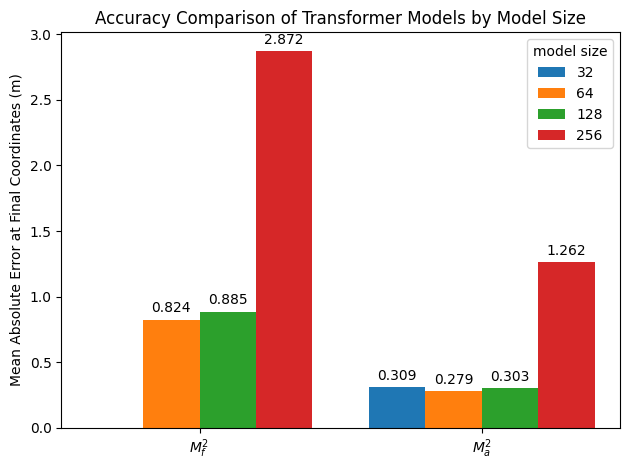

In [40]:
labels = ['$M^2_f$', '$M^2_a$']
category = [32, 64, 128, 256]
cat1_value = [0, 0.309]
cat2_value = [0.824, 0.279]
cat3_value = [0.885, 0.303]
cat4_value = [2.872, 1.262]

group_bar(title="Accuracy Comparison of Transformer Models by Model Size",
            ylabel="Mean Absolute Error at Final Coordinates (m)",
            labels=labels, 
            category=category, 
            cat_values=[cat1_value, cat2_value, cat3_value, cat4_value],
            legend_title="model size")

### 3種類のモデル比較

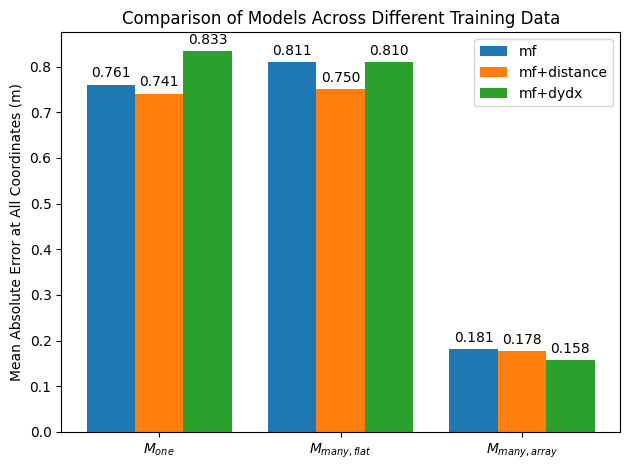

In [ ]:
labels = ['$M_{one}$', '$M_{many,flat}$', '$M_{many,array}$']
category = ['mf', 'mf+distance', 'mf+dydx']
cat1_files = ["2ax_zeros_flat2.pickle", "2ax_zeros_flat.pickle", "2ax_zeros_index.pickle"]
cat2_files = ["2ax_distance_flat2.pickle", "2ax_distance_flat.pickle", "2ax_distance_index.pickle"]
cat3_files = ["2ax_route_flat2.pickle", "2ax_route_flat.pickle", "2ax_route_index.pickle"]
cat1_value = [np.mean(all_data[f][:]) for f in cat1_files]
cat2_value = [np.mean(all_data[f][:]) for f in cat2_files]
cat3_value = [np.mean(all_data[f][:]) for f in cat3_files]

group_bar(title="Comparison of Models Across Different Training Data",
            ylabel="Mean Absolute Error at All Coordinates (m)",
            labels=labels, 
            category=category, 
            cat_values=[cat1_value, cat2_value, cat3_value])

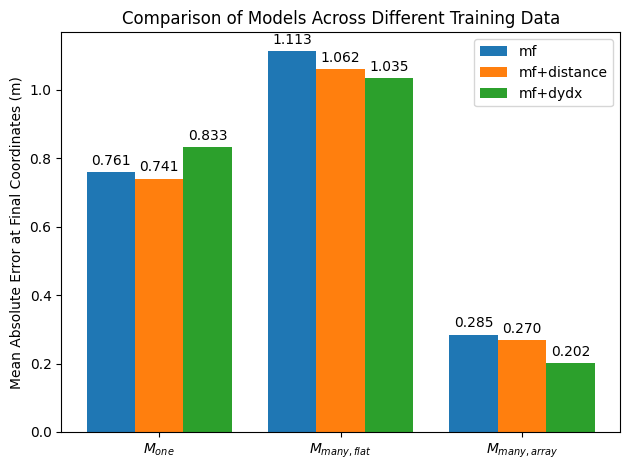

In [11]:
labels = ['$M_{one}$', '$M_{many,flat}$', '$M_{many,array}$']
category = ['mf', 'mf+distance', 'mf+dydx']
cat1_files = ["2ax_zeros_flat2.pickle", "2ax_zeros_flat.pickle", "2ax_zeros_index.pickle"]
cat2_files = ["2ax_distance_flat2.pickle", "2ax_distance_flat.pickle", "2ax_distance_index.pickle"]
cat3_files = ["2ax_route_flat2.pickle", "2ax_route_flat.pickle", "2ax_route_index.pickle"]
cat1_value = [np.mean(all_data[f][:,-1]) for f in cat1_files]
cat2_value = [np.mean(all_data[f][:,-1]) for f in cat2_files]
cat3_value = [np.mean(all_data[f][:,-1]) for f in cat3_files]

group_bar(title="Comparison of Models Across Different Training Data",
            ylabel="Mean Absolute Error at Final Coordinates (m)",
            labels=labels, 
            category=category, 
            cat_values=[cat1_value, cat2_value, cat3_value])

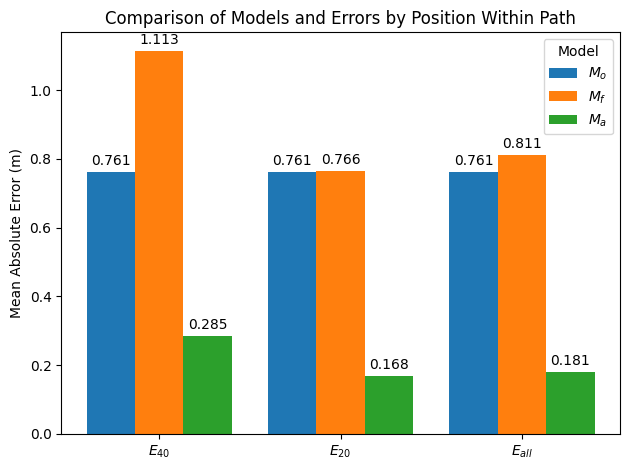

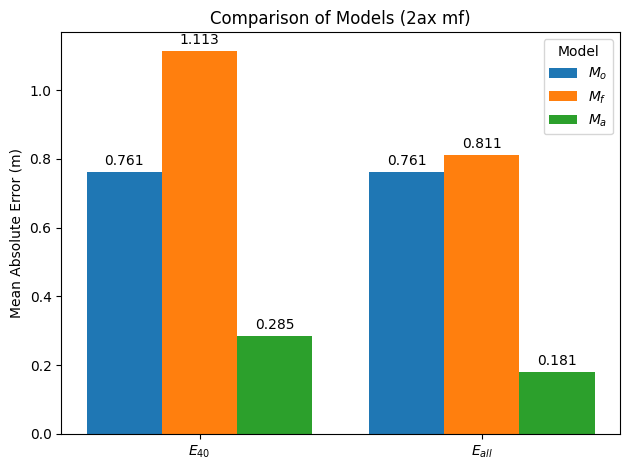

In [12]:
labels = ['$E_{40}$', '$E_{20}$', '$E_{all}$']
category = ['$M_{o}$', '$M_{f}$', '$M_{a}$']
cat_files = ["2ax_zeros_flat2.pickle", "2ax_zeros_flat.pickle", "2ax_zeros_index.pickle"]
cat_values = []
for f in cat_files:
    if f == "2ax_zeros_flat2.pickle":
        cat_values.append([np.mean(all_data[f][:]), np.mean(all_data[f][:]),np.mean(all_data[f][:])])
    else: 
        cat_values.append([np.mean(all_data[f][:,-1]), np.mean(all_data[f][:,-10]), np.mean(all_data[f][:])])
group_bar(title="Comparison of Models and Errors by Position Within Path",
            ylabel="Mean Absolute Error (m)",
            labels=labels, 
            category=category, 
            cat_values=cat_values,
            legend_title="Model")


labels = ['$E_{40}$', '$E_{all}$']
category = ['$M_{o}$', '$M_{f}$', '$M_{a}$']
cat_files = ["2ax_zeros_flat2.pickle", "2ax_zeros_flat.pickle", "2ax_zeros_index.pickle"]
cat_values = []
for f in cat_files:
    cat_values.append([np.mean(all_data[f][:,-1]), np.mean(all_data[f][:])])
group_bar(title="Comparison of Models (2ax mf)",
            ylabel="Mean Absolute Error (m)",
            labels=labels, 
            category=category, 
            cat_values=cat_values,
            legend_title="Model")

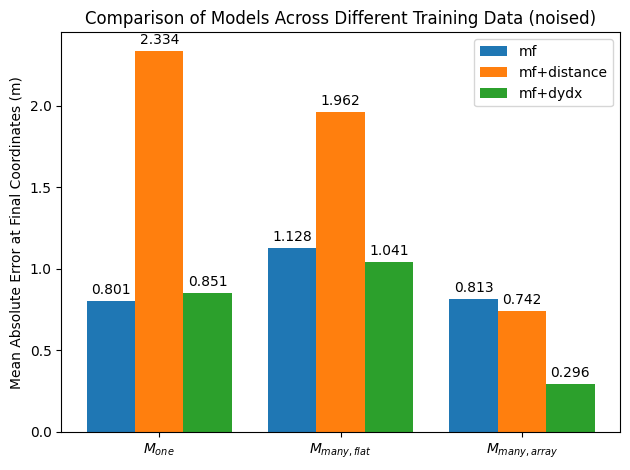

In [13]:
labels = ['$M_{one}$', '$M_{many,flat}$', '$M_{many,array}$']
category = ['mf', 'mf+distance', 'mf+dydx']
cat1_files = ["2ax_zeros_flat2.pickle", "2ax_zeros_flat.pickle", "2ax_zeros_index.pickle"]
cat2_files = ["2ax_distance_flat2.pickle", "2ax_distance_flat.pickle", "2ax_distance_index.pickle"]
cat3_files = ["2ax_route_flat2.pickle", "2ax_route_flat.pickle", "2ax_route_index.pickle"]
cat1_value = [np.mean(all_data[f"noise_{f}"][:,-1]) for f in cat1_files]
cat2_value = [np.mean(all_data[f"noise_{f}"][:,-1]) for f in cat2_files]
cat3_value = [np.mean(all_data[f"noise_{f}"][:,-1]) for f in cat3_files]

group_bar(title="Comparison of Models Across Different Training Data (noised)",
            ylabel="Mean Absolute Error at Final Coordinates (m)",
            labels=labels, 
            category=category, 
            cat_values=[cat1_value, cat2_value, cat3_value])

### ノイズ有無の比較

#### 全データ

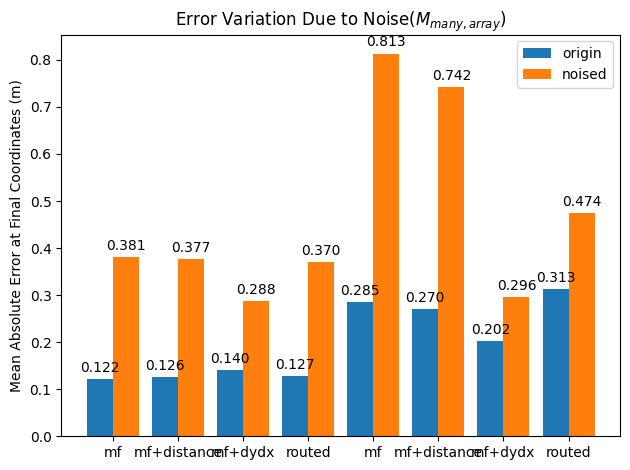

In [14]:
labels = ['mf', 'mf+distance', 'mf+dydx', 'routed', 'mf', 'mf+distance', 'mf+dydx', 'routed']
category = ['origin', 'noised']
cat1_files = ["3ax_zeros_index.pickle", "3ax_distance_index.pickle", "3ax_route_index.pickle", "3ax_routed_index.pickle", "2ax_zeros_index.pickle", "2ax_distance_index.pickle", "2ax_route_index.pickle", "2ax_routed_index.pickle"]
cat1_value = [np.mean(all_data[f][:,-1]) for f in cat1_files]
cat2_value = [np.mean(all_data[f"noise_{f}"][:,-1]) for f in cat1_files]

group_bar(
    title="Error Variation Due to Noise($M_{many,array}$)",
    ylabel="Mean Absolute Error at Final Coordinates (m)",
    labels=labels, 
    category=category, 
    cat_values=[cat1_value, cat2_value]
)

#### 変位(直前座標routed)

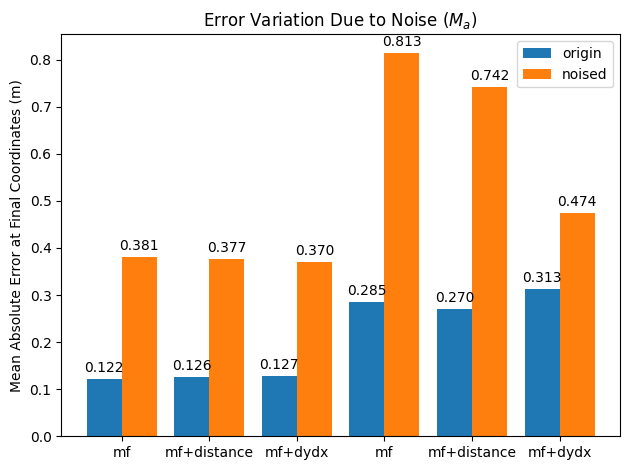

In [15]:
labels = ['mf', 'mf+distance', 'mf+dydx', 'mf', 'mf+distance', 'mf+dydx']
category = ['origin', 'noised']
cat1_files = ["3ax_zeros_index.pickle", "3ax_distance_index.pickle", "3ax_routed_index.pickle", "2ax_zeros_index.pickle", "2ax_distance_index.pickle", "2ax_routed_index.pickle"]
cat1_value = [np.mean(all_data[f][:,-1]) for f in cat1_files]
cat2_value = [np.mean(all_data[f"noise_{f}"][:,-1]) for f in cat1_files]

group_bar(
    title="Error Variation Due to Noise ($M_{a}$)",
    ylabel="Mean Absolute Error at Final Coordinates (m)",
    labels=labels, 
    category=category, 
    cat_values=[cat1_value, cat2_value]
)

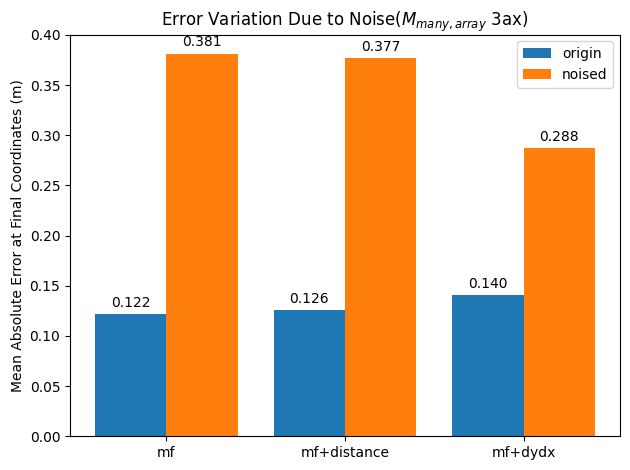

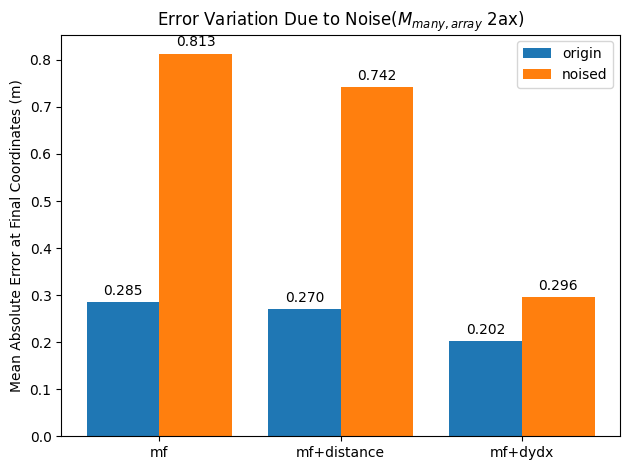

In [16]:
labels = ['mf', 'mf+distance', 'mf+dydx', 'mf', 'mf+distance', 'mf+dydx']
category = ['origin', 'noised']
cat1_files = ["3ax_zeros_index.pickle", "3ax_distance_index.pickle", "3ax_route_index.pickle", "2ax_zeros_index.pickle", "2ax_distance_index.pickle", "2ax_route_index.pickle"]
cat1_value = [np.mean(all_data[f][:,-1]) for f in cat1_files]
cat2_value = [np.mean(all_data[f"noise_{f}"][:,-1]) for f in cat1_files]

group_bar(
    title="Error Variation Due to Noise($M_{many,array}$ 3ax)",
    ylabel="Mean Absolute Error at Final Coordinates (m)",
    labels=labels[:3], 
    category=category, 
    cat_values=[cat1_value[:3], cat2_value[:3]]
)
group_bar(
    title="Error Variation Due to Noise($M_{many,array}$ 2ax)",
    ylabel="Mean Absolute Error at Final Coordinates (m)",
    labels=labels[3:], 
    category=category, 
    cat_values=[cat1_value[3:], cat2_value[3:]]
)

### 経路長による比較

['2ax_zeros_index_len_10.pickle', '2ax_zeros_index_len_2.pickle', '2ax_zeros_index_len_20.pickle', '2ax_zeros_index_len_40.pickle', '2ax_zeros_index_len_5.pickle', '2ax_zeros_index_len_d10.pickle', '2ax_zeros_index_len_d2.pickle', '2ax_zeros_index_len_d20.pickle', '2ax_zeros_index_len_d5.pickle']


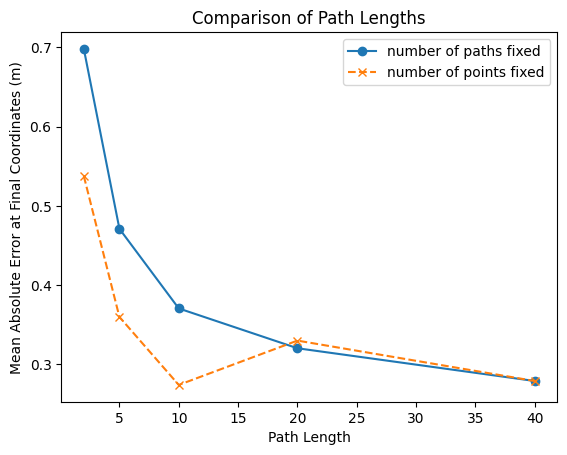

In [17]:
exp2_data = {}
files = get_pickle_files(exp2_out_path)
for key in files.keys():
    with open(files[key], "rb") as f:
        data = pickle.load(f)
        exp2_data[key] = data.reshape(2000, -1)
# pos = -10
pos = -1
path_length = [2, 5, 10, 20, 40]
values = []
divided_values = []
for p in path_length:
    key = f"2ax_zeros_index_len_{p}.pickle"
    v = np.mean(exp2_data[key][:,pos])
    # print(np.shape(exp2_data[key]))
    values.append(v)
    # print(key, v)

for p in path_length[:-1]:
    key = f"2ax_zeros_index_len_d{p}.pickle"
    v = np.mean(exp2_data[key][:,pos])
    divided_values.append(v)
    # print(key, v)
divided_values.append(np.mean(exp2_data["2ax_zeros_index_len_40.pickle"][:,pos]))

plt.plot(path_length, values, linestyle="-", marker="o", label="number of paths fixed")
plt.plot(path_length, divided_values, linestyle="--", marker="x", label="number of points fixed")
plt.title("Comparison of Path Lengths")
plt.xlabel("Path Length")
plt.ylabel("Mean Absolute Error at Final Coordinates (m)")
plt.legend()
plt.show()

# print(exp2_data.keys())

### positionによる比較

In [18]:
def compair_by_pos(method, noised):

    flat_mean_list = []
    array_mean_list = []

    title_append = "2ax mf"


    if method == "distance":
        title_append += "+distance"
    elif method == "route":
        title_append += "+dydx"

    if noised:
        title_append += " noised "


    if noised:
        noised = "noise_"
    else:
        noised = ""



    for i in range(40):
        flat_m = np.mean(all_data[f"{noised}2ax_{method}_flat.pickle"][:,i])
        array_m = np.mean(all_data[f"{noised}2ax_{method}_index.pickle"][:,i])
        flat_mean_list.append(flat_m)
        array_mean_list.append(array_m)

    one_mean = np.mean(all_data[f"{noised}2ax_{method}_flat2.pickle"][:])

    plt.scatter(40, one_mean, label='$M_{o}$', color='red')
    plt.plot(flat_mean_list, label='$M_{f}$', linestyle="--", color='blue')
    plt.plot(array_mean_list, label='$M_{a}$', linestyle="-", color='green')


    plt.xlabel("Position Within Path")  # 経路内の位置
    plt.ylabel("Mean Absolute Error  (m)")
    plt.title(f"Comparison of Errors by Position Within Path({title_append})")  # 経路内の位置による誤差の比較
    plt.legend(title="Model")
    plt.show()

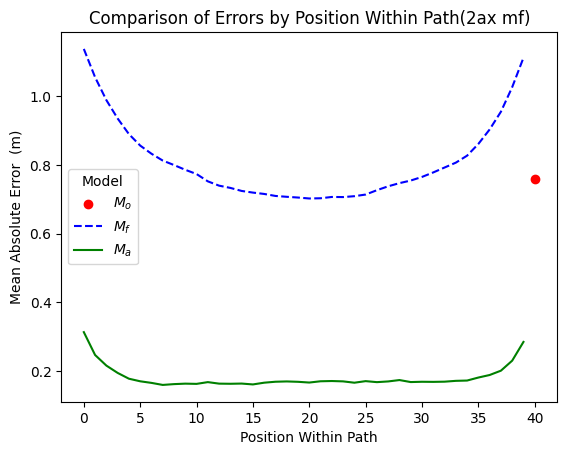

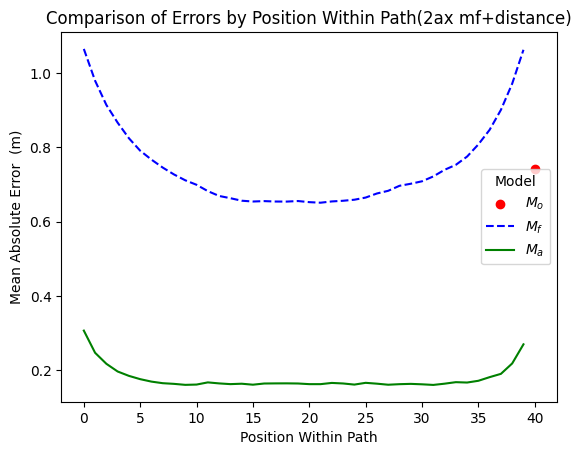

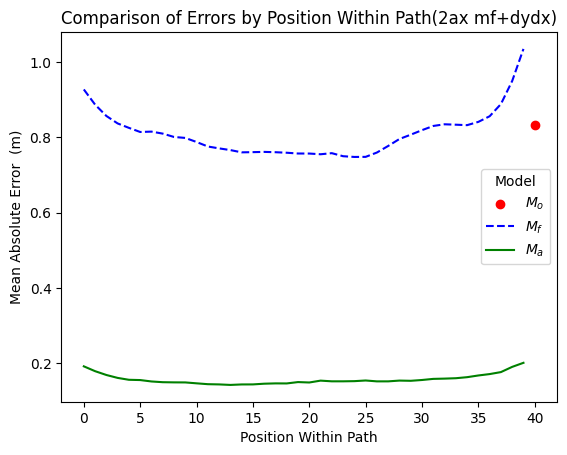

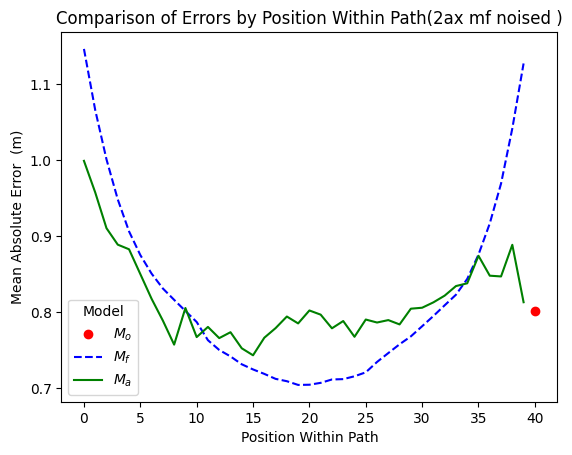

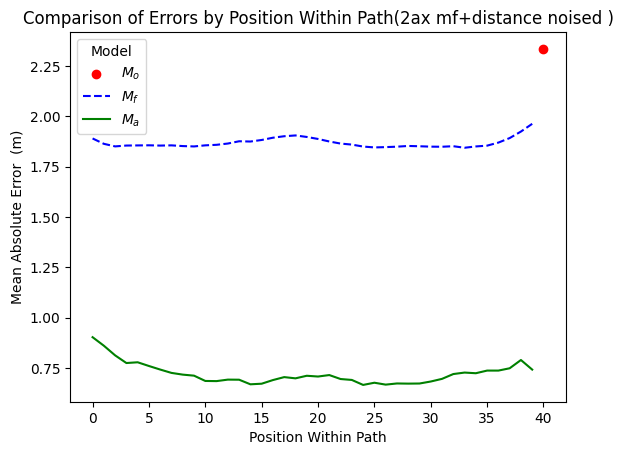

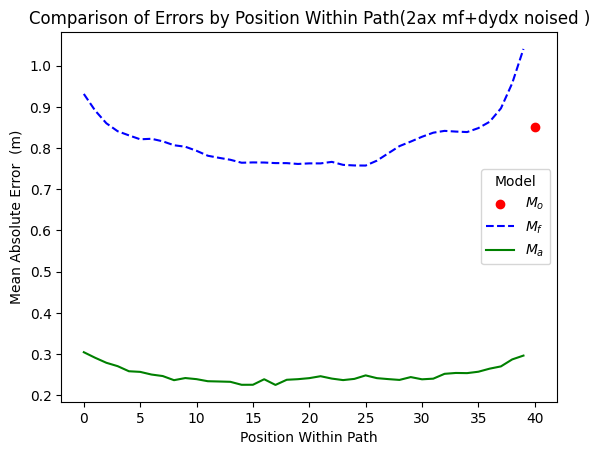

In [19]:
compair_by_pos("zeros", False)
compair_by_pos("distance", False)
compair_by_pos("route", False)
compair_by_pos("zeros", True)
compair_by_pos("distance", True)
compair_by_pos("route", True)

['2ax_zeros_index_len_10.pickle', '2ax_zeros_index_len_2.pickle', '2ax_zeros_index_len_20.pickle', '2ax_zeros_index_len_40.pickle', '2ax_zeros_index_len_5.pickle', '2ax_zeros_index_len_d10.pickle', '2ax_zeros_index_len_d2.pickle', '2ax_zeros_index_len_d20.pickle', '2ax_zeros_index_len_d5.pickle']


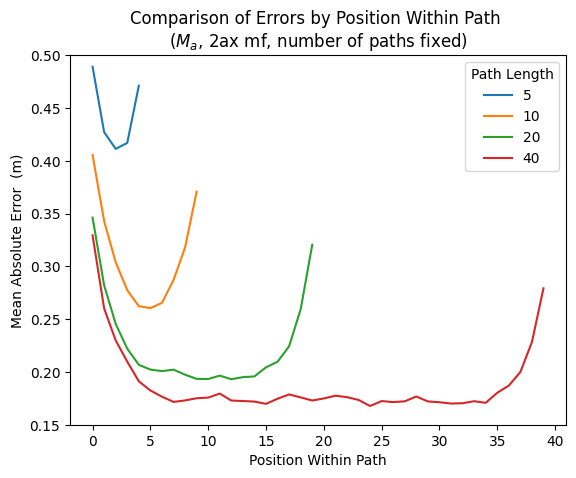

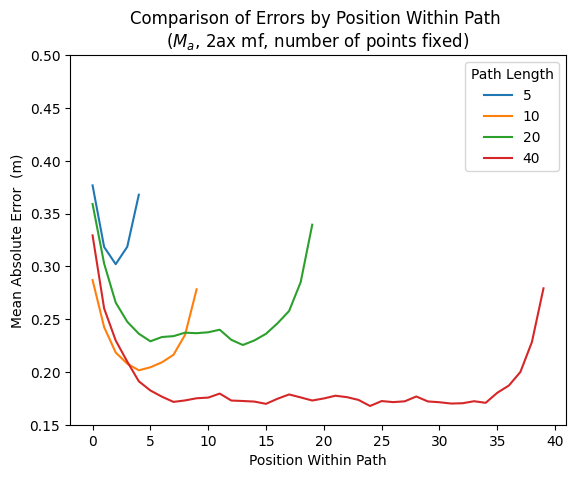

In [27]:
exp2_data = {}
files = get_pickle_files(exp2_out_path)
for key in files.keys():
    with open(files[key], "rb") as f:
        data = pickle.load(f)
        exp2_data[key] = data.reshape(2000, -1)
# pos = -10
pos = -1
path_length = [2, 5, 10, 20, 40]
# values = []
# divided_values = []
# for p in path_length:
#     key = f"2ax_zeros_index_len_{p}.pickle"
#     v = np.mean(exp2_data[key][:,pos])
#     # print(np.shape(exp2_data[key]))
#     values.append(v)
#     # print(key, v)

# for p in path_length[:-1]:
#     key = f"2ax_zeros_index_len_d{p}.pickle"
#     v = np.mean(exp2_data[key][:,pos])
#     divided_values.append(v)
#     # print(key, v)
# divided_values.append(np.mean(exp2_data["2ax_zeros_index_len_40.pickle"][:,pos]))

# plt.plot(path_length, values, linestyle="-", marker="o", label="number of paths fixed")
# plt.plot(path_length, divided_values, linestyle="--", marker="x", label="number of points fixed")
# plt.title("Comparison of Path Lengths")
# plt.xlabel("Path Length")
# plt.ylabel("Mean Absolute Error at Final Coordinates (m)")
# plt.legend()
# plt.show()

# print(exp2_data.keys())

flat_mean_list = []
array_mean_list = []

value_list = []
value_d_list = []

for p in path_length:
    values = []
    key = f"2ax_zeros_index_len_{p}.pickle"
    for i in range(p):
        v = np.mean(exp2_data[key][:,i])
        # print(np.shape(exp2_data[key]))
        values.append(v)
        # print(key, v)
    value_list.append(values)

for p in path_length[:-1]:
    values = []
    key = f"2ax_zeros_index_len_d{p}.pickle"
    for i in range(p):
        v = np.mean(exp2_data[key][:,i])
        values.append(v)
    value_d_list.append(values)

    

# plt.plot(value_list[0], label='2', linestyle="-")
plt.plot(value_list[1], label='5', linestyle="-")
plt.plot(value_list[2], label='10', linestyle="-")
plt.plot(value_list[3], label='20', linestyle="-")
plt.plot(value_list[4], label='40', linestyle="-")


plt.xlabel("Position Within Path")  # 経路内の位置
plt.ylabel("Mean Absolute Error  (m)")
plt.title(f"Comparison of Errors by Position Within Path \n($M_a$, 2ax mf, number of paths fixed)")  # 経路内の位置による誤差の比較
plt.legend(title="Path Length")
plt.ylim(0.15, 0.5)
plt.show()

# plt.plot(value_d_list[0], label='2', linestyle="-")
plt.plot(value_d_list[1], label='5', linestyle="-")
plt.plot(value_d_list[2], label='10', linestyle="-")
plt.plot(value_d_list[3], label='20', linestyle="-")
plt.plot(value_list[4], label='40', linestyle="-")

plt.xlabel("Position Within Path")  # 経路内の位置
plt.ylabel("Mean Absolute Error  (m)")
plt.title(f"Comparison of Errors by Position Within Path \n($M_a$, 2ax mf, number of points fixed)")  # 経路内の位置による誤差の比較
plt.legend(title="Path Length")
plt.ylim(0.15, 0.5)
plt.show()

## 実験1 many_array

In [20]:

load_pickle_files(exp1_many_array_dir)

['2ax_distance_index.pickle', '2ax_routed_index.pickle', '2ax_route_index.pickle', '2ax_zeros_index.pickle', '3ax_distance_index.pickle', '3ax_routed_index.pickle', '3ax_route_index.pickle', '3ax_zeros_index.pickle', 'noise_2ax_distance_index.pickle', 'noise_2ax_routed_index.pickle', 'noise_2ax_route_index.pickle', 'noise_2ax_zeros_index.pickle', 'noise_3ax_distance_index.pickle', 'noise_3ax_routed_index.pickle', 'noise_3ax_route_index.pickle', 'noise_3ax_zeros_index.pickle']
(80000,) (2000, 40) (2000,)
2ax_distance_index.pickle 0.26978695
(80000,) (2000, 40) (2000,)
2ax_routed_index.pickle 0.31341583
(80000,) (2000, 40) (2000,)
2ax_route_index.pickle 0.20173195
(80000,) (2000, 40) (2000,)
2ax_zeros_index.pickle 0.2846516
(80000,) (2000, 40) (2000,)
3ax_distance_index.pickle 0.12563123
(80000,) (2000, 40) (2000,)
3ax_routed_index.pickle 0.12724829
(80000,) (2000, 40) (2000,)
3ax_route_index.pickle 0.14048052
(80000,) (2000, 40) (2000,)
3ax_zeros_index.pickle 0.122036956
(80000,) (2000,

## 実験1 many_flat

In [21]:
load_pickle_files(exp1_many_flat_dir)

['2ax_distance_flat.pickle', '2ax_route_flat.pickle', '2ax_zeros_flat.pickle', 'noise_2ax_distance_flat.pickle', 'noise_2ax_route_flat.pickle', 'noise_2ax_zeros_flat.pickle']
(80000,) (2000, 40) (2000,)
2ax_distance_flat.pickle 1.0621102
(80000,) (2000, 40) (2000,)
2ax_route_flat.pickle 1.0347321
(80000,) (2000, 40) (2000,)
2ax_zeros_flat.pickle 1.1128577
(80000,) (2000, 40) (2000,)
noise_2ax_distance_flat.pickle 1.9620962
(80000,) (2000, 40) (2000,)
noise_2ax_route_flat.pickle 1.0409129
(80000,) (2000, 40) (2000,)
noise_2ax_zeros_flat.pickle 1.1276405


## 実験1 one

In [22]:
load_pickle_files(exp1_one_flat_dir)

['2ax_distance_flat2.pickle', '2ax_route_flat2.pickle', '2ax_zeros_flat2.pickle', '3ax_distance_flat2.pickle', '3ax_route_flat2.pickle', '3ax_zeros_flat2.pickle', 'noise_2ax_distance_flat2.pickle', 'noise_2ax_route_flat2.pickle', 'noise_2ax_zeros_flat2.pickle', 'noise_3ax_distance_flat2.pickle', 'noise_3ax_route_flat2.pickle', 'noise_3ax_zeros_flat2.pickle']
(2000,) (2000, 1) (2000,)
2ax_distance_flat2.pickle 0.740984
(2000,) (2000, 1) (2000,)
2ax_route_flat2.pickle 0.8333823
(2000,) (2000, 1) (2000,)
2ax_zeros_flat2.pickle 0.76073426
(2000,) (2000, 1) (2000,)
3ax_distance_flat2.pickle 0.48799437
(2000,) (2000, 1) (2000,)
3ax_route_flat2.pickle 0.5670589
(2000,) (2000, 1) (2000,)
3ax_zeros_flat2.pickle 0.49666485
(2000,) (2000, 1) (2000,)
noise_2ax_distance_flat2.pickle 2.3338501
(2000,) (2000, 1) (2000,)
noise_2ax_route_flat2.pickle 0.8506964
(2000,) (2000, 1) (2000,)
noise_2ax_zeros_flat2.pickle 0.8012852
(2000,) (2000, 1) (2000,)
noise_3ax_distance_flat2.pickle 0.51741785
(2000,) (2

## 実験2

In [22]:
load_pickle_files(exp2_out_path)

['2ax_zeros_index_len_10.pickle', '2ax_zeros_index_len_2.pickle', '2ax_zeros_index_len_20.pickle', '2ax_zeros_index_len_40.pickle', '2ax_zeros_index_len_5.pickle', '2ax_zeros_index_len_d10.pickle', '2ax_zeros_index_len_d2.pickle', '2ax_zeros_index_len_d20.pickle', '2ax_zeros_index_len_d5.pickle']
2ax_zeros_index_len_10.pickle 0.39336056
2ax_zeros_index_len_2.pickle 0.6783001
2ax_zeros_index_len_20.pickle 0.33952212
2ax_zeros_index_len_40.pickle 0.27916124
2ax_zeros_index_len_5.pickle 0.4465227
2ax_zeros_index_len_d10.pickle 0.27423748
2ax_zeros_index_len_d2.pickle 0.5374878
2ax_zeros_index_len_d20.pickle 0.33011022
2ax_zeros_index_len_d5.pickle 0.3599053


## 実験0(事前実験)


In [24]:
load_pickle_files(exp0_out_path)

['2ax_zeros_flat_in80_d128_out40.pickle', '2ax_zeros_flat_in80_d256_out40.pickle', '2ax_zeros_flat_in80_d64_out40.pickle', '2ax_zeros_index_d128.pickle', '2ax_zeros_index_d256.pickle', '2ax_zeros_index_d32.pickle', '2ax_zeros_index_d64.pickle']
2ax_zeros_flat_in80_d128_out40.pickle 0.88544977
2ax_zeros_flat_in80_d256_out40.pickle 2.8725195
2ax_zeros_flat_in80_d64_out40.pickle 0.8241039
2ax_zeros_index_d128.pickle 0.30329785
2ax_zeros_index_d256.pickle 1.2620363
2ax_zeros_index_d32.pickle 0.3092818
2ax_zeros_index_d64.pickle 0.27916124
